# `pyscses` - python space charge site explicit solver

## Overview

`pyscses` is a Python module that implements a site-explicit, one-dimensional Poisson-Boltzmann solver, used for modelling ionic space charge properties in solid materials. In polycrystalline solid materials, grain boundaries and interfaces exist separating different crystalline domains. The structural distortion at these interfaces causes segregation of charge carriers to, or away from the grain boundary core. Due to this, the grain boundary core carries a net charge which causes the depletion or accumulation of charge carriers in the regions adjacent, known as space charge regions. Due to the variation on charge carrier concentrations, the ionic conductivity of the material can be strongly affected by the presence of grain boundaries.Space charge properties such as electrostatic potential, charge density and charge carrier distributions over the space charge region can be calculated using the Poisson-Boltzmann equation from the input of defect segregation energies and atomically resolved charge carrier positions. The grain boundary resistivity and activation energy can be calculated by extending the model using the calculated charge carrier distributions. `pyscses` also accounts for different approximations typically assumed when space charge formation is considered. These approximations include site explicit vs. continuum modelling, Mott-Schokkty (single mobile defect species) and Gouy-Chapman (all defect species mobile) conditions, and whether the charge of the non-defective species should be considered.

## The Poisson-Boltzmann equation

The standard continuum approach to modelling the interfacial properties in solid electrolytes is commonly to seek solutions to the Poisson-Boltzmann equation.
It is possible to calculate the defect concentration in boundary layers due to the equality of electrochemical potentials between the boundary layer and the bulk at spatial equilibrium. 
In crystals structures, defects occupy defined sites, therefore the chemical potential of a Fermi-Dirac distribution gives a more realistic expression for the defect concentrations.

$$
\mu^o_{i,x} + RT\ln \left( \frac{c_{i,x}}{1-c_{i,x}} \right) + z_i F \Phi_x = \mu^o_{i,\infty} + RT\ln \left(\frac{c_{i,\infty}}{1- c_{i,\infty}}\right) + z_i F \Phi_{\infty},
$$

where $\mu^o$ is the standard chemical potential, $c_{\infty}$ is the concentration of defects in the bulk, $c_i,x$ is the concentration of defect $i$ at a given site $x$, $z$ is the valence and $F$ is the Faraday constant, $R$ is the gas constant and $T$ is the temperature in Kelvin.
The equality of chemcial potentials is rearranged to give an expression for the defect concentration at each site,

$$
c_i = \frac{c_\infty \exp\left(\frac{-z_i\Phi_x + \mu_i}{kT}\right)}{1+ c_{\infty} \left(\exp\left( \frac{-z_i\Phi_x + \mu_i}{kT} \right) -1 \right) }.
$$

In a system of point charges, the charge density is proportional to the defect concentrations, given by

$$
\rho = \sum_i c_i z_i F,
$$

where $\rho$ is the charge density, which is linked to the electrostatic potential via Poisson's equation

$$
\nabla^2\Phi = \frac{-\rho}{\epsilon \epsilon_0},
$$

where $\Phi$ is the local electrostatic potential, $\epsilon$ is the relative permittivity of a given material and $\epsilon_0$ is the vacuum permitivity.

For solid electrolytes, the Poisson-Boltzmann equation is commonly solved by treating the grain boundary via the boundary condition by setting the grain boundary potential. However the grain boundary can be treated explicitly by solving the Poisson-Boltzmann equation using segregation energies of defects $\Delta E_{i,x}$. The segregation energy  is defined as the difference in energy between the energy of a defect at its site and the energy of a defect in the bulk.

$$ \Delta E_{i,x} = E_{i,x} - E_{i,\infty} $$

Including the correct site statistics and the segregation energies, the Poisson-Boltzmann equation becomes

$$ \nabla^2\Phi = - \frac{1}{\epsilon \epsilon_0} \sum_i c_{i,\infty} \frac{ x_{i,\infty} \exp \frac{-z_i F \Phi_x + \Delta E_{i,x} }{k_BT} }{1 + x_{i,\infty} \left( \exp \frac{-z_i F \Phi_x + \Delta E_{i,x} }{k_BT} -1 \right) } z_i F $$

## Solving the Poisson-Boltzmann equation
### Using a finite difference approximation

The Poisson-Boltzmann equation can be solved numerically using a finite dfference approximation for the second order partial differential equation. To solve the Poisson-Boltzmann equation numerically, the second order partial derivatives need to be replaced with second-order finite difference approximations using Taylor series expansion. The differential equations then become a system of linear algebraic equations, which can be solved using matrix algebra.

In this work, the sites described are the one-dimensional projection of defects in a crystal lattice onto a grid. In real crystals, lattice sites are not necessarily equally spaced and therefore the finite difference equations must be defined to take into account different $\Delta x$ spacings.

<img src="Figures/irregulargrid.png">

For an irregularly space grid, the first derivatives are given as,

$$ 
f'_{x,a} = \frac{f_{x0} - f_{x-1}}{\Delta x_1},
$$

$$
f'_{x,b} = \frac{f_{x1} - f_{x0}}{\Delta x_2},
$$

and the second derivative is given as 

$$
f''_0 = \frac{ f'_{x,b} - f'_{x,a} }{ \frac{1}{2}(\Delta x_1 + \Delta x_2 )}.
$$

This can be expanded using the full expression for $f'_{x,a}$, and rearranged, 

$$ 
f''_0 = \frac{2 ( \Delta x_2 ( f_{x0} - f_{x-1} ) - \Delta x_1(f_{x+1} - f_{x0} ) )}{\Delta x_1 \Delta x_2 (\Delta x_1 + \Delta x_2 ) }.
$$

Taking the second derivative finite difference at every point in $[x_0, x_2]$ then gives the following expression.

$$ 
f''_0 = \frac{-2}{\Delta x_1 \Delta x_2 (\Delta x_1 +\Delta x_2 ) } . \left[\Delta x_2f_{x-1} - ( \Delta x_1 + \Delta x_2 ) f_0 + \Delta x_1 f_{x+1}\right] 
$$

To solve the Poisson-Boltzmann equation, the function at each position is the electrostatic potential and the second derivative is solved to calculate the charge density at each position. Substituting $\Phi$ and $\rho$ yields the equation

$$-\rho = \frac{-2}{\Delta x_1 \Delta x_2 (\Delta x_1 +\Delta x_2 ) } . \left[ \Delta x_2\Phi_{x-1} - ( \Delta x_1 + \Delta x_2 ) \Phi_0 + \Delta x_1 \Phi_{x+1} \right] $$

To find the solution of the discretised Poisson-Boltzmann equation, the above expression must be satisfied at all points on the grid. Therefore, these equations become a system of linear algebraic equations solved using matrix inversion. Matrix inversion is known as the process of finding matrix $b$ which satisfies the equation of an invertible matrix $A$. 

Taking prefactor ($p$) as:

$$ p = \frac{-2}{\Delta x_1 \Delta x_2 (\Delta x_1 +\Delta x_2 ) } $$

$A$ as:

$$ A = \Delta x_2\Phi_{x-1} - ( \Delta x_1 + \Delta x_2 ) \Phi_0 + \Delta x_1 \Phi_{x+1} $$

and $b$ as:

$$ b = -\rho $$

The Poisson-Boltzmann equation can be solved. 

The invertible matrix $A$ becomes:

$A$ =
$\begin{pmatrix}
(\Delta x_i + \Delta x_{i+1}) & \Delta x_{i+1} & 0 & 0 & 0 \\
\Delta x_i & (\Delta x_i + \Delta x_{i+1}) & \Delta x_{i+1} & 0 & 0 \\
0 & \Delta x_i & (\Delta x_i + \Delta x_{i+1}) & \Delta x_{i+1} & 0 \\
0 & 0 & \Delta x_i & (\Delta x_i + \Delta x_{i+1}) & \Delta x_{i+1} \\
0 & 0 & 0 & \Delta x_i & (\Delta x_i + \Delta x_{i+1})
\end{pmatrix}$

To account for the prefactor, a new matrix $L$ is constructed. $L$ is created by transposing matrix $A$, multiplying it by the prefactor and then transposing the matrix again.

$$ L = ( A^T . p )^T $$

Vector $b$ is created from values of $\rho$

$b$ =
$\begin{pmatrix}
\rho_1 \\
\rho_2 \\
\rho_3 \\
\rho_4 \\
\rho_5 \\
\end{pmatrix}$

$ \Phi = L^{-1} b $ is solved using ```numpy.linalg.solve``` which gives $\Phi_{new}$. This process is iterated until a preset convergence limit between is met.

To control numerical stability in reaching the convergence limit, a damping factor is used to reduce the jump in values of $\Phi$ between iterations. 

$$ \Phi_{i+1} = \alpha\Phi_{i+1} + ( 1.0 - \alpha)\Phi_i $$

# Using the code to solve the Poisson-Boltzmann equation

The space charge model implemented in this code is, as desribed above, one dimensional, with a series of discrete sites at values of $x$ over a given region. 
These $x$ coordinates, along with the segregation energies required as input for the solver can be generated using atomistic modelling of a given system.

The majority of the code used is stored externally and is imported in to the notebook, along with the standard python modules, numpy, pandas and matplotlib.

In [1]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/project')

from project.defect_species import DefectSpecies
from project.set_of_sites import Set_of_Sites
from project.constants import boltzmann_eV
from project.calculation import Calculation, calculate_activation_energies
from project.set_up_calculation import calculate_grid_offsets
from project.grid import Grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Defining the model

Here the model that will be used is defined.


```boundary_conditions``` - Either ```'dirichlet'``` where the boundaries of the calculation are fixed to 0.0, or ```'periodic'``` where the boundaries of the calculation are equivalent. 

```site_charges``` - Either ```True``` where the charge of all species is considers or ```False``` where only the charge of the defect species is considered.

```systems``` - Either ```'mott-schottky'``` where certain defect species are considered immobile and are fixed to their bulk defect distribution or ```'gouy-chapman'``` where all defect species are considered mobile and are able to redistribute.

```core_models``` - Either ```'single'```, where the core is considered using a single segregation energy at the center of the grain boundary. ```'multi-site'```, where the core is divided into layers with fixed segregation energies, when the segregation energy of a site is less that $k_BT$ or greater than $-k_BT$, the segregation energy is fixed to 0.0. Or ```False```, where all segregation energies are considered. 

```site_models``` - Either ```'site_explicit```, where all sites are considered at their lattice positions or ```continuum``` where the segregation energies are interpolated onto a regular grid.

In [2]:
boundary_conditions = 'dirichlet'
site_charges = False
systems = 'gouy-chapman'
core_models = False
site_models = 'continuum'

### Defining variables
Here the variables are defined. These are required for the calculation to run.

```alpha``` - is a damping parameter used to damp the updates to the potential during every iteration to help convergence and numerical stability.

```conv``` -  is the convergence limit that the difference between the calculated potential and the damped potential must be before convergence is accepted. 

```grid_x_min / grid_x_max``` - define the region either side of the grain boundary that will be included in the calculation.

```bulk_x_min / bulk_x_max ``` - define a region of bulk which can be used to calculate bulk properties

```dielectric``` - The relative permittivity of the material. In this case Gd-doped CeO2.

```index``` - The grain boundary orientation selected for the calculation.

```b / c``` - The width and height of the cell used in the atomistic simulation when defect segreagtion energies were calculated. Specific to the grain boundary orientation.

```temp``` - Temperature (K).

In [3]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -2.0e-8
grid_x_max = +2.0e-8
bulk_x_min = -2.0e-8
bulk_x_max = -1.0e-8

dielectric = 1

index = 111

b = 5e-9
c = 5e-9

temp = [773.15]

### Defining system specific constants.

The code that is imported calculates the grain boundary properties for any system. In the cell below the properties for a given system are defined. 

```valence``` - defect charge

```site_labels``` - ```site_1``` / ```site_2``` - labels defining the species that would be occupying the site in the pure material

```defect_labels``` - ```defect_1``` / ```defect_2``` - labels defining the defect species occupying the site in the defective material

```mole_fractions``` - the bulk mole fractions of the defect species

```initial_guess``` - an initial guess for the bulk defect mole fractions, used in a minimisation to correct the output mole fractions when ```gouy_chapman``` conditions are applied. 

The values must be input in the order [ mobile defect property, immobile defect property ].

#### Example
To demonstrate how the system specific constants would be implemented using real data an example system of gadolinium doped ceria is shown.

```python
valence = [ +2.0, -1.0 ]
site labels = [ 'O', 'Ce' ]
defect_labels = [ 'Vo', 'Gd' ]
mole_fractions = [ [ 0.05, 0.2 ] ]

percentage_dopant = 20
initial_guess = [ [ 0.05, 0.2 ] ]
```

However for the purpose of this example notebook we are not using any particular system. The site labels are defined as site_1/site_2 and the defect labels are defined as defect_1/defect_2 with equal but opposite valence and equal mole fractions.

In [4]:
valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']
mole_fractions = [ [ 0.2, 0.2 ] ]

percentage_dopant = 20
initial_guess = [ [ 0.2, 0.2 ] ]

### Input data

Following this, the path to the data file is defined and stored in ```data```. 

In [5]:
data = '/Users/glw33/source/project/userguides/input_data/example_data_2_one_seg_energies.txt'

The input for the solver is a .txt file where each line in the file corresponds to a different site.

Each line in the .txt file needs to be a string containing the following information:

**Site label** - site_1 / site_2 - A label defining the species that would be occupying the site in pure ceria. 

**Site charge** - The charge of the non-defective site species.

**$x$ coordinate** - float - The x coordinate for the position of the site.

**Defect label** - defect_1 / defect_2 -  A label defining the defect species occupying the site.

**Segregation energy** The defect segregation energy for that defect occupying that site.

For example:

```
site_2   +1.0   -2e-09    defect_2    0.0
site_1   -1.0   -2e-09    defect_1    0.0
site_2   +1.0   -1e-09    defect_2    0.0
site_1   -1.0   -1e-09    defect_1    0.0
site_2   +1.0    0.0      defect_2    0.0
site_1   -1.0    0.0      defect_1   -1.0
site_1   +1.0    1e-09    defect_1    0.0
site_2   -1.0    1e-09    defect_2    0.0
site_1   +1.0    2e-09    defect_1    0.0
site_2   -1.0    2e-09    defect_2    0.0
```

In this example system, each $x$ coordinate on a regularly spaced grid (-50 nm to +50 nm with 1 nm spacings) has one positively charged defect (```defect_one```) and one negatively charged defect (```defect_2```). These defects are equal and opposite in their valence and therefore the system is charge neutral. For simplicity, all of the defects have a segregation energy of zero, except the central positively charged defect which has a segregation energy of -1.0 eV.



### Running the calculation

The limits are the widths between the midpoint of the final site and an 'imaginary' site extending beyond the calculation unit. These are calculated to use in delta_x calculations where the width of each site is required to calculate volumes or densities. 
```
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )
```

If the calculation is being run over a number of different conditions, the mole fractions are looped over. 
```
for m in mole_fractions:
```

Next the different defect species are defined using the ```Defect_Species``` class. This collects and stores the information about each defect, the defect label, the defect valence and the defect mole fraction.

```
defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
```
The information is passed into the ```site_from_input_file``` function in set_up_calculation.py, which creates a site using the ```Site``` class. The Site class collects and stored all of the information about each site and the defects at the site. It has the site label, the $x$ coordinate, ```defect_species``` at the site (which contains the defect label, defect valence and defect mole fraction)and the defect segregation energy. These sites are then collected and stored in a Set_of_Sites class which groups together the sites and is used for calculations involving all the sites as a whole system rather than calculations on the sites independently. 

```
all_sites = Set_of_Sites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charge, core, temp )
```

A grid is created using the ```Grid``` class. This includes the array of $x$ coordinates, b/c (the width and height of the cell used in the atomistic simulation) and the full set of sites ```all_sites```

```
grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
```

If the calculation is being run over a number of different conditions, the temperatures are looped over.

```
for t in temp:
```

Space charge models typically consider dopant ions as either mobile or immobile. If the dopant ions are considered immobile, the model follows a Mott-Schottky approximation. If the dopant ions are considered mobile, the model follows a Gouy-Chapman approximation. This code includes both approximations. If ```fixed = True``` the mole fraction of the dopant ion is fixed to the bulk mole fraction throughout the iterations and therefore follows the Mott-Schottky approximation, simulating immobile dopant ions. If ```fixed = False ``` the dopant ions redistribute to their equilibrium positions, following the Gouy-Chapman approximation, simulating mobile dopant ions. The default setting is ```False```.

```
if system == 'mott-schottky':
    for site in all_sites.subset( 'site_2' ):
        site.defect_with_label( 'defect_2' ).fixed = True
if system == 'gouy-chapman':        
    for site in all_sites.subset( 'site_2' ):
        site.defect_with_label('defect_2').fixed = False
```

Following this, a Calculation object is created. This class contains the functions which calculate the space charge properties if the system.

```
c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
```

Subgrids are created for each of the defect species.

```
c_o.form_subgrids( site_labels )
```

If the system follows Gouy-Chapman conditions, and periodic boundary conditions are being enforced, a mole fraction correction is required to ensure the output bulk mole fraction is equivalent to the input bulk mole fraction. This function runs the Poisson-Boltzmann calculation and minimises the difference between the target and output mole fractions. This is not required when running the calculation using Mott-Schottky conditions. 

```
c_o.mole_fraction_correction( m, system )
```

Next, the Poisson-Boltzmann equation is solved for the given system. The potential and charge density are calculated. This uses a function ```calculation``` which takes arguments os ``` grid, conv, temp, alpha and boundary_conditions ```. The ```calculation``` function creates numpy arrays the same length as the grid including zeros for the potential (```phi```) and the charge density (```rho```). 

 **Solving the Poisson-Boltzmann equation**

1. The invertible matrix $A$ is created from the distances between each of the points on the grid. Initially the full matrix is created using ```scipy.sparse.diags```  and is then converted into a sparse tridiagonal matrix using ```scipy.sparse.csc_matrix``` and the calculation follows the finite difference approximation method defined above. 
2. The convergence is initialised as 1 and while it is larger than ```conv``` defined in the notebook the calculation will iterate. 
3. Using the ```phi``` array of zeros, the charge density is calculated at each site. Using the calculated value for the charge density at each site $\Phi = A^{-1}b$ is solved using ```scipy.linalg.spsolve```. This returns ```predicted_phi``` at each site, which is damped using $\alpha$ to become the new ```phi``` array. The convergence is updated using $\frac{ \sum_i ( ( \Phi_{predicted} - \Phi )^2 )}{L_{grid.x}}$ where $L_{grid.x}$ is the length of the grid.

```
c_o.solve(system)
```

Using the calculated equilibrium electrostatic potentials at each site, the defect mole fractions can be calculated. 
```
c_o.mole_fractions()
```


As mentioned above, the data used for this first example has a series of sites which have $x$ coordinates on a regularly spaced grid (-50 nm to +50 nm with 1 nm spacings). Each site has one positively charged defect (defect_one) and one negatively charged defect (defect_2). These defects are equal and opposite in their valence and therefore the system is charge neutral. For simplicity, all of the defects have a segregation energy of zero, except the central positively charged defect which has a segregation energy of -1.0 eV. As there are positively charged defects and negatively charged defects at each site this particular system acts as though it is using a continuum model where any defect can occupy any site. This is particularly clear when the data is plotted and the potential, charge denisty and defect mole fraction profiles are smooth.

In this example, Dirichlet boundary conditions are enforced. This ensures the potential at the boundary sites is set to 0.0.  

In [6]:
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

    all_sites = Set_of_Sites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, temp )
    
    if systems == 'mott-schottky':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = True
    if systems == 'gouy-chapman':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = False
    grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
    
    for t in temp:
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        c_o.solve(systems)
        c_o.mole_fractions()

The potential, charge density and defect mole fractions can then be plotted as a function of their $x$ coordinate using ```matplotlib.pyplot```.


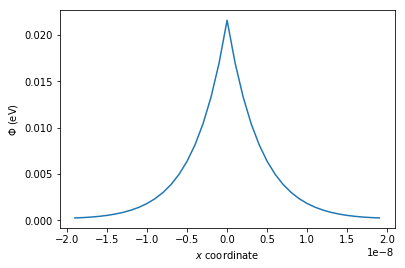

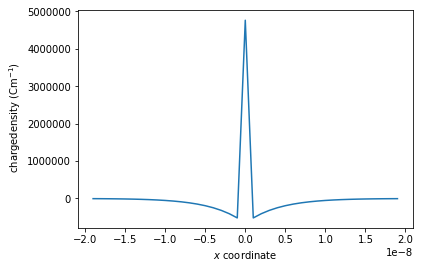

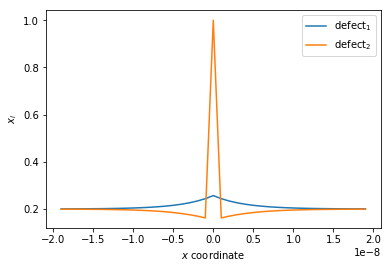

In [7]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

The next example also has a series of sites with $x$ coordinates on a regularly spaced grid (-50 nm to +50 nm with 1 nm spacings), however defects are specific to their sites. In this example, there is a site with two positively charged defects, followed by two sites which each have one negatively charged defects. This system almost simulates a system such as gadolinium doped ceria which has a +2 defect followed by two -1 defects, however using two defects which are equal but opposite in their valence. The concentration and positively and negatively charged defects are equal and therefore the system is charge neutral. In this case all of the sites have a segregation energy of zero which demonstrates how the defects would be arranged in the bulk structure and how this affects the potential.

In this example, Dirichlet boundary conditions are enforced which ensures the potential at the boundary sites is 0.0.

In [8]:
data_1 = '/Users/glw33/source/project/userguides/input_data/example_data_3_alternate_sites.txt'

In [9]:
site_models = 'site_explicit'

limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

    all_sites = Set_of_Sites.set_of_sites_from_input_data( data_1, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, temp )
    
    if systems == 'mott-schottky':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = True
    if systems == 'gouy-chapman':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = False
    grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
    
    for t in temp:
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        c_o.solve(systems)
        c_o.mole_fractions()

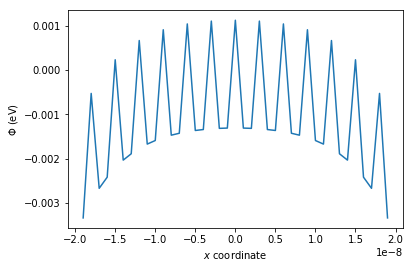

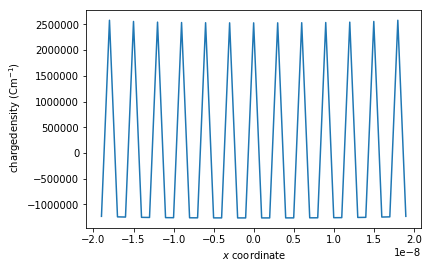

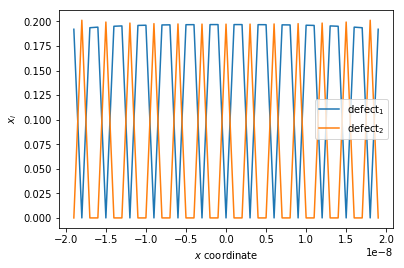

In [10]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

When using Dirichlet boundary conditions the potential at the boundary sites is fixed to 0.0. It can be seen from the figure above showing the potential against the $x$ coordinate, with this example using data which depicts alternating sites, the potential profile curves. This happens because no matter what the potential is calculated to be, the potential is forced to zero at the boundaries. In this example, the boundary sites are occupied by negatively charged defects and therefore these sites should have a slightly negative potential. The Dirichlet boundary conditions force these sites to have a potential of zero and therefore the potential profile curves. The change in the potential profile effects the charge density, causing the system to become negatively charged, losing charge neutrality. 

To prevent this from happening periodic boundary conditions can be enforced. Periodic boundary conditions consider the region of data as a unit cell with the final site equivalent to the initial site but not fixed to any particular value.

In [11]:
boundary_conditions = 'periodic'

limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

    all_sites = Set_of_Sites.set_of_sites_from_input_data( data_1, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, temp )
    
    if systems == 'mott-schottky':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = True
    if systems == 'gouy-chapman':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = False
    grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
    
    for t in temp:
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        c_o.mole_fraction_correction( m, systems )
        c_o.solve(systems)
        c_o.mole_fractions()

[[ 0.2026592   0.19141074]]
[[ 0.20265921  0.19141074]]
[[ 0.2026592   0.19141075]]
[[ 0.19671029  0.20718964]]
[[ 0.1967103   0.20718964]]
[[ 0.19671029  0.20718965]]
[[ 0.20004057  0.20000651]]
[[ 0.20004058  0.20000651]]
[[ 0.20004057  0.20000652]]
[[ 0.19999809  0.19999909]]
[[ 0.1999981   0.19999909]]
[[ 0.19999809  0.1999991 ]]


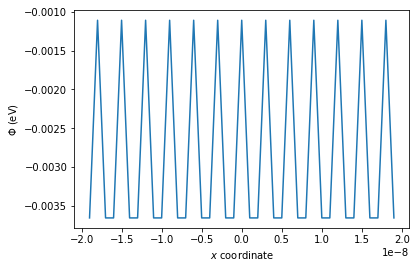

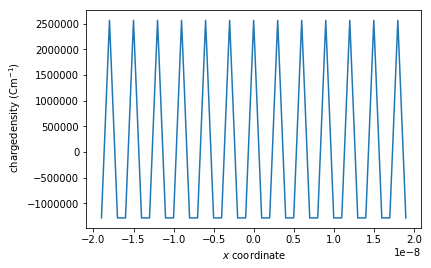

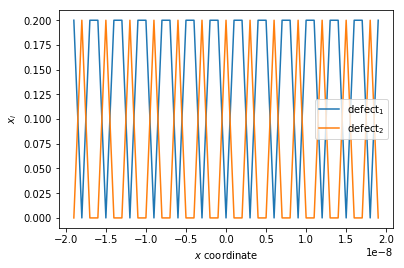

In [12]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

As shown above, when the periodic boundary conditions are used, the average charge across the system is 0.0 and the boundary potential is no longer being forced to 0.0 but is calculated along with the other sites using the Poisson-Boltzmann solver. 
The periodic boundary conditions can also be used with a system similar to the first example, where the central defect has a segregation energy of -1.0 eV but where the defects are specific to their sites.

In [13]:
data_2 = '/Users/glw33/source/project/userguides/input_data/example_data_4_alternate_sites_one_defect.txt' 

In [14]:
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

    all_sites = Set_of_Sites.set_of_sites_from_input_data( data_2, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, temp )
    
    if systems == 'mott-schottky':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = True
    if systems == 'gouy-chapman':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = False
    grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
    
    for t in temp:
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        c_o.mole_fraction_correction( m, systems )
        c_o.solve(systems)
        c_o.mole_fractions()

[[ 0.19913919  0.19203811]]
[[ 0.1991392  0.1920381]]
[[ 0.19913919  0.19203811]]
[[ 0.20061908  0.20650762]]
[[ 0.2006191   0.20650762]]
[[ 0.20061908  0.20650763]]
[[ 0.20001478  0.20000097]]
[[ 0.20001479  0.20000097]]
[[ 0.20001478  0.20000098]]
[[ 0.19999789  0.20000018]]
[[ 0.1999979   0.20000017]]
[[ 0.19999789  0.20000018]]


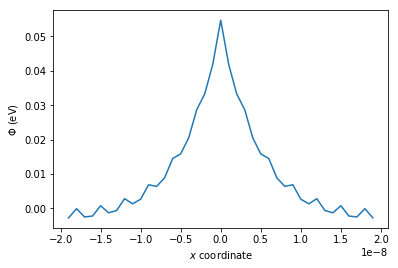

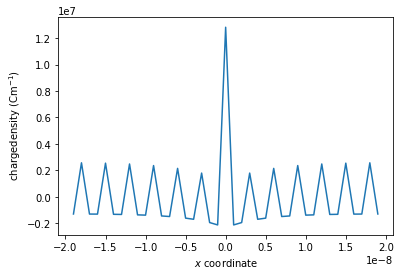

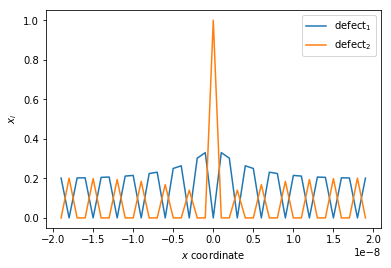

In [15]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

# Using the Poisson-Boltzmann solver with the Mott-Schottky approximation.

As described earlier, space charge models typically consider dopant ions as either mobile or immobile. If the dopant ions are considered immobile, the model follows a Mott-Schottky approximation. If the dopant ions are considered mobile, the model follows a Gouy-Chapman approximation. All the previous examples have demonstrated systems under Gouy-Chapman conditions, where all defects are able to redistribute. In this next example 

```python
for site in all_sites.subset( 'site_2' ):
        site.defect_with_label('defect_2').fixed = True
``` 
        
and the mole fraction of the dopant ion is fixed to the bulk mole fraction throughout the iterations following the Mott-Schottky approximation. 

In [16]:
systems = 'mott-schottky'

limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

    all_sites = Set_of_Sites.set_of_sites_from_input_data( data_2, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, temp )
    
    if systems == 'mott-schottky':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = True
    if systems == 'gouy-chapman':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = False
    grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
    
    for t in temp:
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        c_o.solve(systems)
        c_o.mole_fractions()

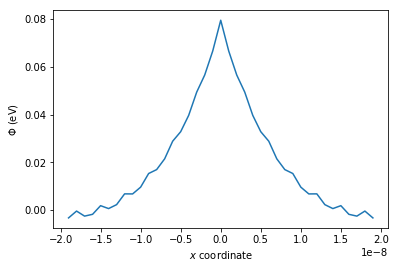

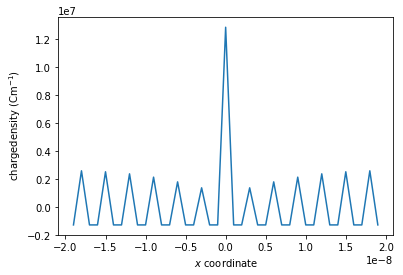

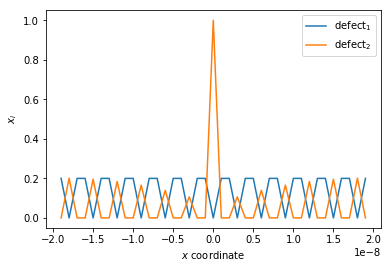

In [17]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

It can be seen in the figures above that when ```fixed = True ``` and the Poisson-Boltzmann equation is being calculated under Mott-schottky conditions ```defect_1``` is able to redistribute whilst ``` defect_2 ``` is fixed to its bulk value. As the negatively charged ```defect_2``` are fixed to its bulk positions they are not electrostatically attracted to the positively charged grain boundary core caused by the segregation of the positively charged ```defect_1```. This causes a larger electrostatic potential at the grain boundary core as the segregation is not limited by the repulsion of the negatively charged defects adjacent to the core and also a broader potential profile as the negatively charged defects are not shielding the positive potential.

# Calculating the resistivity of the grain boundary.

Once the Poisson-Boltzmann solver has converged, the potential, charge density and defect distributions have reached their equilibrium values. Using these equilibrium values the resistivity and activation energy can be calculated.

Taking the resistivity ($\rho$) as 
$$ \rho = \frac{1}{\sigma} = \frac{1}{ c \mu z }$$

Where $\sigma$ is the conductivity, $c$ is the concentration, $\mu$ is the mobility and $z$ is the valence. Treating each site as a resistor in series, the grain boundary resistivity can be calculated by taking the ratio of the sum of the resistivity at all sites to the resistivity in the bulk.

$$ r_{GB} = \frac{\rho_{i,x}}{\rho_{i, \infty }} = \frac{ c_{i, \infty} \mu_i x_i }{\sum_x c_{i,x} \mu_i z_i } $$

Assuming constant mobility for the mobile defect across the space charge regions, the grain boundary resistivity becomes:

$$ r_{GB} = \frac{c_{i,\infty}}{\sum_x c_{i,x} } $$

The resistivity ratio calculation in the code is only suitable when the Poisson-Boltzmann solver is used under the Mott-Schottky approximation as this method assumes that there is only one mobile defect. Once the resisitivity ratio has been calculated, it can be extended into an activation energy from the Arrhenius relationship.

$$ E_a = \frac{\mathrm{d ln}r_{GB}}{\mathrm{d}\left( \frac{1}{k_BT} \right) } $$

Below, the resistivity ratio has been calculated for the system where defects are specific to their sites, there is a site with two positively charged defects, followed by two sites which each have one negatively charged defect. The central positively charged defects have a segregation energy of -1.0 eV and the negatively charged defects are fixed to their bulk mole fractions under the Mott-Schottky approximation. The figure below shows the grain boundary resistivity for the system at a range of temperatures between 773.15 K and 1273.15 K. The resistivity decreases as temperature increases as expected.  

The function to calculate the resistivity ratio takes two arguments. The first argument is whether the space charge potential is positive or negative, and the second argument is a limit for the potential to cut off the sites included in the calculation when the potential is less than or greater than the limit.
```
c_o.calculate_resistivity_ratio_new('positive', -4e-2)
```

In [1]:
dielectric = 50
b = 1e-9
c = 1e-9

temp = [ 773.15, 873.15, 973.15, 1073.15, 1173.15, 1273.15 ]
mole_fractions = [[0.2,0.2]]


resistivity_ratio_list = []

limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

    all_sites = Set_of_Sites.set_of_sites_from_input_data( data_2, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, temp )
    
    if systems == 'mott-schottky':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = True
    if systems == 'gouy-chapman':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = False
    grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
    
    for t in temp:
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio_new( 'positive', 2e-2  )
        
        resistivity_ratio_list.append( c_o.resistivity_ratio )

NameError: name 'calculate_grid_offsets' is not defined

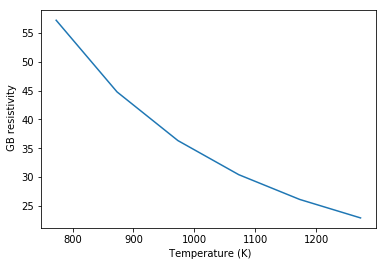

In [19]:
plt.plot( temp, resistivity_ratio_list)
plt.xlabel( ' Temperature (K)' )
plt.ylabel( ' GB resistivity' )
plt.show()

The activation energy can then be calculated from the Arrhenius relationship as described above using the ```calculate_activation_energy``` function in the source code. The function takes the resistivity ratio and temperature as input, calculates $x$ as $\frac{1}{T}$ and $y$ as $ \mathrm{ln} \left( \frac{1}{r_{GB}}\right) $. The slope at each point is calculated using a central difference method and the activation energy is calculated as the slope * Boltzmann constant. 

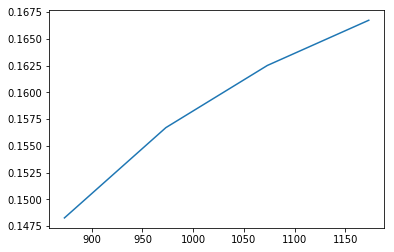

In [20]:
Ea = calculate_activation_energies( resistivity_ratio_list, temp ) 
plt.plot( temp[1:-1], Ea[1:-1] )

# Mott-Schottky model for calculating the space charge potential

Analysis of grain boundary effects on ionic conductivity typically considers the space-charge potential as a characteristic parameter. However $r_{GB}$ can be obtained directly from experimental impedance spectroscopy, whereas the space charge potential cannot and is therefore approximated using the Mott-Schottky model. 

$$ r_{GB} = \frac{\rho_{i,x}}{\rho_{i,\infty}} = \frac{\mathrm{exp}(z\Phi_0 / k_BT)}{2z \Phi_0 / k_BT } $$

The conventional Mott-Schottky analysis assumes that the grain boundart region is negligably thin and that oxygen vacancies are fully depleted in the space-charge region. This gives an analytical description of the space-charge behaviour which can be completely characterised from the space charge potential. 

By calculating the grain boundary resistivity of the system, the Mott-Schotty model can be used to calculate the space charge potential allowing a comparison between the value calculated using the Poisson-Boltzmann solver and the value calculated using the Mott-Schottky model. 

Using ```sympy.solvers.solve ``` the function required to solve the Mott-Scottky model for $\Phi$ was calculated. 

```
x = Symbol('x')
y = Symbol('y')

print( solve (exp(x) / ( 2 * x ) - y, x )  )


[-LambertW(-1/(2*y))]
```

A function named ```solve_MS_for_phi``` was created in the source code which takes the input ```y```, the grain boundary resistivity, and returns ``` -mpmath.lambertw(-1/(2*y),k=-1) ```. The output for this is then multiplied by the Boltzmann constant, and the temperature, and divided by the charge to give the space charge potential.

The function to calculate the Mott-Schottky aprroximation for the space charge potential takes one argument, and that is the charge of the mobile defect.
```
c_o.solve_MS_approx_for_phi( valence[0] )
```

In [21]:
space_charge_potential_list = []
MS_space_charge_potential_list =[]
temp = [ 773.15, 873.15, 973.15, 1073.15, 1173.15, 1273.15 ]
mole_fractions = [[0.2,0.2]]

limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

    all_sites = Set_of_Sites.set_of_sites_from_input_data( data_2, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, temp )
    
    if systems == 'mott-schottky':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = True
    if systems == 'gouy-chapman':
        for site in all_sites.subset( 'site_2' ):
            site.defect_with_label('defect_2').fixed = False
    grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
    
    for t in temp:
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        c_o.solve(systems)
        space_charge_potential_list.append(max(c_o.phi))
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio_new( 'positive', 2e-2  )
        c_o.solve_MS_approx_for_phi( valence[0] )
        MS_space_charge_potential_list.append(c_o.ms_phi)

The space-charge potential calculated using the Mott-Schottky model can be compared to the space-charge potential calculated using the Poisson-Boltzmann solver as demonstrated below.

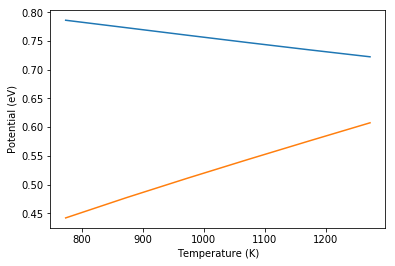

In [22]:
plt.plot( temp, space_charge_potential_list, label = '$\Phi_0^{PB}$' )
plt.plot( temp, MS_space_charge_potential_list, label = ' $\Phi_0^{MS}' )
plt.xlabel( 'Temperature (K)' )
plt.ylabel( 'Potential (eV)' )
plt.show()

# The Debye length and space charge width

The Poisson-Boltzmann equation can be manipulated to give the Debye length. The Debye length is the "characteristic length scale" from the Debye-Huckel equation, which is the linearised Poisson-Boltzmann equation used for dilute systems.

$$ L_D = \left( \frac{\epsilon \epsilon_0 k_BT}{2 F^2 c_{i, \infty } } \right) ^ \frac{1}{2} $$

Where $L_D$ is the Debye length, $\epsilon$ is the dielectric, $\epsilon_0$ is the vacuum permittivity, $k_B$ is the Boltzmann constant, $T$ is the temperature, $F$ is Faraday's constant and $c_{i,\infty}$ is the bulk defect density. 
$L_D$ is then used to calculate the width of the space charge region.

$$ \delta_{sc} = 2L_D \left(\frac{\Phi_0 z}   {k_BT} \right)^ \frac{1}{2}$$

Where $\Phi_0$ is the space charge potential. The space charge potential can be calculated from the Poisson-Boltzmann equation or from the Mott-Schottky model to find their respective space charge widths. 

# Using the Poisson-Boltzmann solver code with real data. 

This example uses real data generated for the 111 grain boundary orientation in gadolinium doped ceria ( $\mathrm{Gd-CeO_2}$ ). The data was generated using METADISE which is a computer program that performs atomic scale simulations of crystal structures. These simulations allow dislocations, surfaces and interfaces to be studied. METADISE has been used to study a number of grain boundaries in gadolinium doped ceria and individual defect energies and positions were calculated for gadolinium ions at cerium sites and vacancies at oxygen sites. 

In [27]:
alpha = 0.0005
conv = 1e-8
grid_x_min = -6.094e-9
grid_x_max = 5.16e-9
bulk_x_min = -5.783e-9
bulk_x_max = -2.502e-9

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp = [ 773.15 ]

In [28]:
data_3 = '/Users/glw33/source/project/userguides/input_data/Gd_CeO2_111_data.txt'

In [29]:
valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.05, 0.2 ] ])

### Running the Poisson-Boltzmann solver and calculating the grain boundary properties.

In [30]:
limits, laplacian_limits = calculate_grid_offsets( data_3, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m ) for l, v, m in zip( defect_labels, valence, m ) }

        all_sites = Set_of_Sites.set_of_sites_from_input_data( data_3, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
        c_o.form_subgrids( site_labels )
        #c_o.mole_fraction_correction( m, systems )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio_new('positive', 2e-2)
        c_o.solve_MS_approx_for_phi( valence[0] )

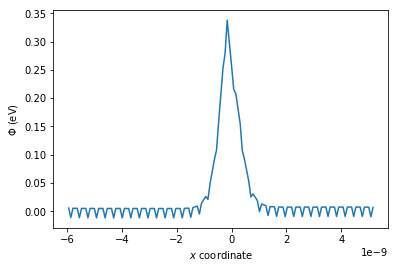

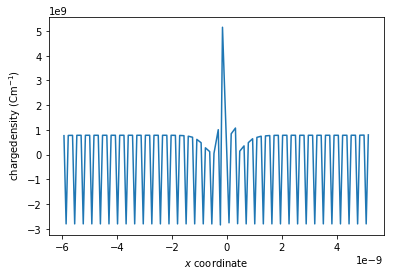

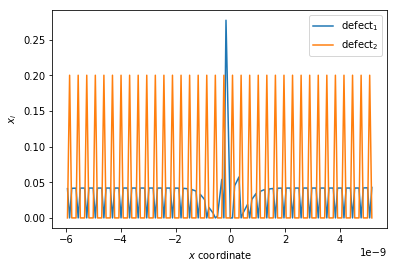

In [32]:
# Plotting the potential, charge density and defect mole fractions for the last calculation.
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()